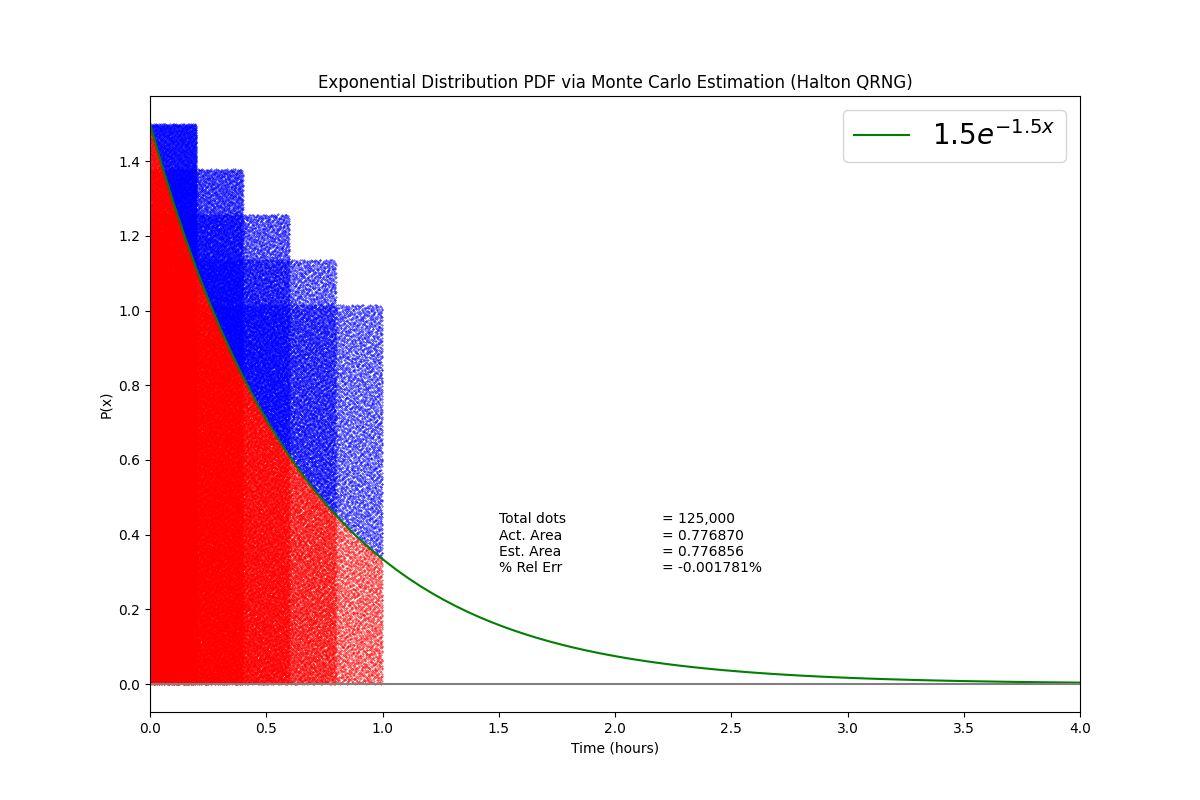

In [134]:
"""mc_exp_dist.ipynb"""
# Cell 1 

# This code uses Monte Carlo estimation to calculate the probability an event will occur 
# within one hour of an exponential distribution having a rate parameter of 90 minutes.

# Code is modified from that given by Dr. David Biersach in mc_std_normal.ipynb. 

# Code is aided by: 
# https://courses.lumenlearning.com/introstats1/chapter/the-exponential-distribution/
# https://en.wikipedia.org/wiki/Exponential_distribution#Random_variate_generation 


# Used for type hinting
from __future__ import annotations
# Used for type hinting
import typing
# Used for plotting 
import matplotlib.pyplot as plt
# Used for calculations
import numpy as np
# Used for graphing style
from matplotlib.markers import MarkerStyle
# Allows us to use large numbers to increase algorithm efficiency 
from numba import float64, vectorize  # type: ignore
# Integration for the area under the curve 
from scipy.integrate import quad #type:ignore

if typing.TYPE_CHECKING:
    # Type checking for axes and arrays 
    from matplotlib.axes import Axes
    from numpy.typing import NDArray


# Allows the menu bar on the side of the plot to appear 
%matplotlib widget


def f(x: NDArray[np.float_], rate_parameter: float) -> NDArray[np.float_]:
    """Actual implementation of exponential distribution pdf"""
    # Helps us determine if we are above or below the curve 
    # f(x)= 1.5e^(-1.5*x)-> pdf
    return rate_parameter *(np.e**(-rate_parameter*x))



# vectorize-> numba package to make it run fast 
@vectorize([float64(float64, float64)], nopython=True)  # type: ignore
def halton(n: float, p: int) -> float:
    """Generate random points"""
    # Takes an index (n) and a base (p) as its inputs 
    # Initialize h and f 
    h = 0
    f = 1
    # loop runs until index becomes 0 
    while n > 0:
        # Scale down the factor to create digits in Halton sequence 
        f: float = f / p
        # Calculate the remainder of n/p and multiply it by f 
            # Update h in the overall halton sequence 
        h += (n % p) * f
        # Update n by performing integer division 
        n = int(n / p)
    return h



def plot_exponential_distribution(ax: Axes) -> None:
    # 25,000 dots 
    iterations: int = 25_000

   # rate parameter of 90 min, but the plot will be in hours 
    rate_parameter: float = 1.5

    # 2 dimensions, give halton 1st 2 primes 
    primes: list[int] = [2, 3]


    # To limit error-> 
    # Divide the Monte Carlo sampling area into 5 different rectangles, each with increasing x and decreasing y
        
    # how many sampling rectangles we will make 
    breaks: int= 5
    # Initially scaling factors for x and y based on the outputs of the Halton series 
    scale_factor_y: float = 1.5 
    scale_factor_x: float = 0.2
    # Initialize our counter for the number of points that fall within the graph 
    count_points: int = 0
    # While loops runs until we plot 5 distinct rectangles 
    while breaks>0: 
        # halton gives us a number between 0 and 1, scale x and y to be in our sample space
        x: NDArray[np.float_] = halton(np.arange(iterations), primes[0])*scale_factor_x # type: ignore
        y: NDArray[np.float_] = halton(np.arange(iterations), primes[1])  *scale_factor_y# type: ignore

        # distance -> difference between actual height - y value we picked 
            # tells us are we above or below 
        d: NDArray[np.float_] = f(x,rate_parameter) - y
    
        # filters to make 2 different lists 
            # inner points have a distance greater than/equal to 0 
        x_in: NDArray[np.float_] = x[d >=0.0]
        y_in: NDArray[np.float_] = y[d >=0.0]
            # outer points have a distance less than 0 
        x_out: NDArray[np.float_] = x[d <0.0 ]
        y_out: NDArray[np.float_] = y[d <0.0 ]
        # Count the number of points within the area, and add that number to count_points for each iteration
        count_points += np.count_nonzero(d >=0.0)
        # Decrease the scale_y factor and increase the scale_x factor 
        scale_factor_y= scale_factor_y-0.121
        scale_factor_x= scale_factor_x+0.2
        # Decrease the number of rectangles 
        breaks= breaks-1  
        # inside are plotted in red, outside blue-> plot 5 rectangles 
        pixel_size: float = (72 / ax.figure.dpi) ** 2  # type: ignore
        ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
        ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)
        
    # plot actual 
        # define arrays of the actual x and y values based on the actual PDF of the exponential distribution
    act_x: NDArray[np.float_] = np.linspace(0, 5, 100)
    act_y: NDArray[np.float_] = f(act_x, rate_parameter)
    ax.plot(
        act_x, act_y, color="green", label=r"$1.5e^{-1.5x}$" 
    )
    # Monte carlo formula 
        # calculate the estimated area based on the inner points and the iterations
            # Since we plotted 5 rectangles each with 25_000 iterations, multiply iterations by 5 
    est_area: float = count_points / (iterations*5)

    # Calculate the actual area using scipy integrate function 
    act_area: float = quad(f, 0, 1.0, args=(rate_parameter,))[0]
    # Calculate the error 
    err: float = (est_area - act_area) / act_area
    
    ax.set_title("Exponential Distribution PDF via Monte Carlo Estimation (Halton QRNG)")
    ax.set_xlim(0.0, 4.0)
    ax.set_xlabel ("Time (hours)")
    ax.set_ylabel("P(x)")
    ax.axhline(0, color="gray")
    ax.axvline(0, color="gray")
    ax.legend(loc="upper right", fontsize="20")

    ax.text(1.5, 0.3, "Total dots\nAct. Area\nEst. Area\n% Rel Err", ha="left")

    # fmt: off
    ax.text(2.2, 0.3,
        f"= {iterations*5:,}\n= {act_area:.6f}\n= {est_area:.6f}\n= {err:.6%}", ha="left")
    # fmt: on


def main() -> None:
    """Define an entry point for the code"""
    # Open a new plot window and show the plot 
    # closes all previous plot windows
    plt.close("all")
    # define how big you want the image to be in inches
    plt.figure(" ", figsize=(12, 8))
    plot_exponential_distribution(plt.axes())
    plt.show()

# Call the main function 
main()